# Code Summary

This Python script analyzes the differential expression of regulatory genes in genomic data. It:

1. Loads a list of regulatory overlapping genes from a text file and maps them to their Ensembl IDs using a GTF annotation file

2. Retrieves differential expression data for these genes from a DESeq2 analysis comparing "YAF vs GFP" conditions

3. Classifies each regulatory gene as:
   - Upregulated (log2FoldChange > 0, padj < 0.01)
   - Downregulated (log2FoldChange < 0, padj < 0.01)
   - Not significant

4. Creates a bar chart showing the percentage of regulatory genes that are upregulated vs downregulated

5. Saves the results as:
   - A complete CSV with all regulatory genes and their expression data
   - Separate CSV files for upregulated and downregulated genes
   - Visualization plots in PNG and PDF formats

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# %% 
# Define file paths
regulatory_genes_file = "../SRF_H2AK119Ub/1_iterative_processing/analysis/11_gene_overlap_analysis/all_overlapping_genes.txt"
diff_expr_file = "../SRF_RNA/results/deseq2/YAF_vs_GFP/differential_expression.csv"
gtf_file = "../COMMON_DATA/gencode.v43.basic.annotation.gtf"
output_dir = "../SRF_RNA/results/regulatory_genes_analysis"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [2]:
# Read the list of regulatory overlapping genes
with open(regulatory_genes_file, 'r') as f:
    regulatory_genes = [line.strip() for line in f.readlines() if line.strip()]

print(f"Loaded {len(regulatory_genes)} regulatory overlapping genes")

Loaded 2044 regulatory overlapping genes


In [3]:
# Create a mapping from gene symbol to Ensembl ID by parsing the GTF file
gene_symbol_to_ensembl = {}

In [4]:
# If mapping is insufficient, use a more comprehensive approach with the entire GTF file
print("Initial mapping was insufficient, trying a more comprehensive approach...")

# Set to track processed gene symbols to avoid duplicates
processed_genes = set()

with open(gtf_file, 'r') as f:
    line_count = 0
    for line in f:
        line_count += 1
        if line_count % 100000 == 0:
            print(f"Processed {line_count} lines from GTF file...")
            
        if line.startswith('#'):
            continue
            
        fields = line.strip().split('\t')
        if fields[2] == 'gene':
            attributes = fields[8]
            
            # Extract gene_id and gene_name
            gene_id = None
            gene_name = None
            
            for attr in attributes.split(';'):
                if 'gene_id' in attr:
                    gene_id = attr.strip().split(' ')[1].replace('"', '')
                if 'gene_name' in attr:
                    gene_name = attr.strip().split(' ')[1].replace('"', '')
            
            if gene_id and gene_name and gene_name in regulatory_genes and gene_name not in processed_genes:
                # Remove version number from gene_id if present
                gene_id = gene_id.split('.')[0]
                gene_symbol_to_ensembl[gene_name] = gene_id
                processed_genes.add(gene_name)
                
                # Break early if we've found all the genes
                if len(gene_symbol_to_ensembl) == len(regulatory_genes):
                    break

print(f"After comprehensive mapping: {len(gene_symbol_to_ensembl)} gene symbols mapped to Ensembl IDs")

Initial mapping was insufficient, trying a more comprehensive approach...
Processed 100000 lines from GTF file...
Processed 200000 lines from GTF file...
Processed 300000 lines from GTF file...
Processed 400000 lines from GTF file...
Processed 500000 lines from GTF file...
Processed 600000 lines from GTF file...
Processed 700000 lines from GTF file...
Processed 800000 lines from GTF file...
Processed 900000 lines from GTF file...
Processed 1000000 lines from GTF file...
Processed 1100000 lines from GTF file...
Processed 1200000 lines from GTF file...
Processed 1300000 lines from GTF file...
Processed 1400000 lines from GTF file...
Processed 1500000 lines from GTF file...
Processed 1600000 lines from GTF file...
Processed 1700000 lines from GTF file...
Processed 1800000 lines from GTF file...
Processed 1900000 lines from GTF file...
After comprehensive mapping: 2043 gene symbols mapped to Ensembl IDs


In [5]:
# Function to get gene ID with version
def get_gene_id_with_version(ensembl_id, diff_expr_df):
    # First try exact match
    if ensembl_id in diff_expr_df.index:
        return ensembl_id
    
    # Then try matching the base ID (without version number)
    matching_ids = [idx for idx in diff_expr_df.index if idx.startswith(ensembl_id + '.')]
    if matching_ids:
        return matching_ids[0]
    
    return None

In [6]:
# Read differential expression data
diff_expr_df = pd.read_csv(diff_expr_file, index_col=0)
print(f"Loaded differential expression data for {len(diff_expr_df)} genes")

Loaded differential expression data for 37665 genes


In [7]:
# Define thresholds for differential expression
padj_threshold = 0.01
log2fc_threshold = 0.0

In [8]:
# Analyze regulatory genes in differential expression data
regulatory_diff_expr = []

for gene_symbol, ensembl_id in gene_symbol_to_ensembl.items():
    gene_id_with_version = get_gene_id_with_version(ensembl_id, diff_expr_df)
    
    if gene_id_with_version and gene_id_with_version in diff_expr_df.index:
        gene_data = diff_expr_df.loc[gene_id_with_version]
        
        regulatory_diff_expr.append({
            'gene_symbol': gene_symbol,
            'ensembl_id': gene_id_with_version,
            'baseMean': gene_data['baseMean'],
            'log2FoldChange': gene_data['log2FoldChange'],
            'padj': gene_data['padj'],
            'is_significant': gene_data['padj'] < padj_threshold,
            'regulation': 'Upregulated' if gene_data['log2FoldChange'] > log2fc_threshold and gene_data['padj'] < padj_threshold else
                         'Downregulated' if gene_data['log2FoldChange'] < -log2fc_threshold and gene_data['padj'] < padj_threshold else
                         'Not significant'
        })

regulatory_df = pd.DataFrame(regulatory_diff_expr)
print(f"Found differential expression data for {len(regulatory_df)} regulatory genes")

Found differential expression data for 1997 regulatory genes


In [9]:
# Summarize the regulation status
regulation_counts = regulatory_df['regulation'].value_counts()
print("\nRegulation status of regulatory genes:")
print(regulation_counts)


Regulation status of regulatory genes:
regulation
Not significant    1163
Downregulated       645
Upregulated         189
Name: count, dtype: int64


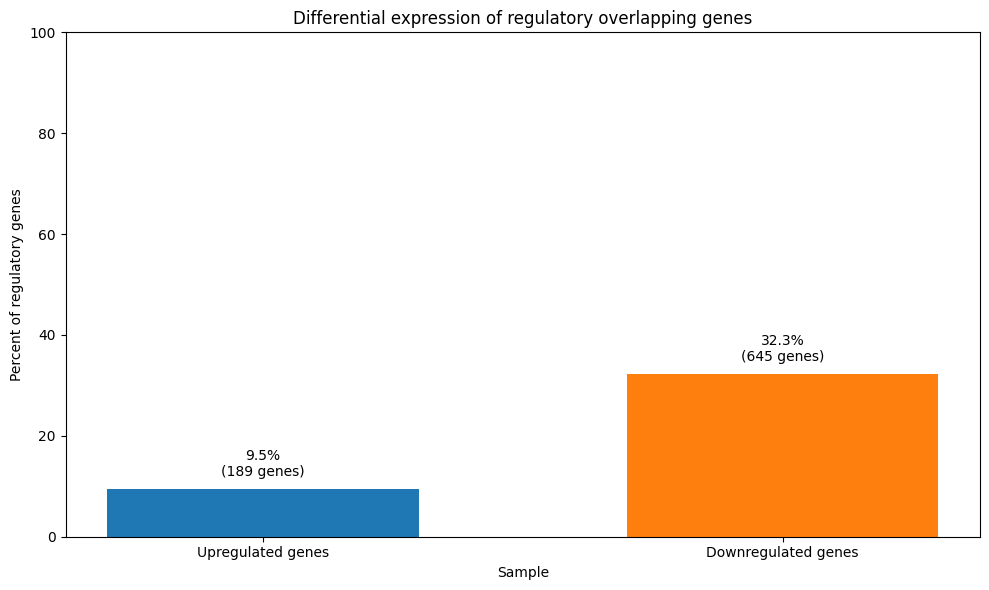

In [10]:
# Create a bar plot
plt.figure(figsize=(10, 6))

# Count genes by regulation status
up_count = len(regulatory_df[regulatory_df['regulation'] == 'Upregulated'])
down_count = len(regulatory_df[regulatory_df['regulation'] == 'Downregulated'])
not_sig_count = len(regulatory_df[regulatory_df['regulation'] == 'Not significant'])
not_found_count = len(regulatory_genes) - len(regulatory_df)

# Calculate percentages
total_found = len(regulatory_df)
up_percent = (up_count / total_found) * 100 if total_found > 0 else 0
down_percent = (down_count / total_found) * 100 if total_found > 0 else 0

# Create the bar plot
categories = ['Upregulated genes', 'Downregulated genes']
values = [up_percent, down_percent]

x = np.arange(len(categories))
width = 0.6

plt.bar(x, values, width, color=['#1f77b4', '#ff7f0e'])

plt.xlabel('Sample')
plt.ylabel('Percent of regulatory genes')
plt.title('Differential expression of regulatory overlapping genes')
plt.xticks(x, categories)
plt.ylim(0, 100)

# Add count labels on the bars
for i, v in enumerate(values):
    plt.text(i, v + 2, f"{v:.1f}%\n({[up_count, down_count][i]} genes)", 
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'regulatory_genes_expression.png'))
plt.savefig(os.path.join(output_dir, 'regulatory_genes_expression.pdf'))
plt.show()

In [11]:
# Save the results to CSV
regulatory_df.to_csv(os.path.join(output_dir, 'regulatory_genes_expression.csv'), index=False)

# Save lists of up and down regulated genes
regulatory_df[regulatory_df['regulation'] == 'Upregulated'][['gene_symbol', 'ensembl_id', 'log2FoldChange', 'padj']].to_csv(
    os.path.join(output_dir, 'upregulated_regulatory_genes.csv'), index=False)

regulatory_df[regulatory_df['regulation'] == 'Downregulated'][['gene_symbol', 'ensembl_id', 'log2FoldChange', 'padj']].to_csv(
    os.path.join(output_dir, 'downregulated_regulatory_genes.csv'), index=False)

In [12]:
print(f"\nAnalysis complete. Results saved to {output_dir}") 


Analysis complete. Results saved to ../SRF_RNA/results/regulatory_genes_analysis
